In [2]:
from ENDFtk.tree import Tape
from NDSampler import NDSampler, SamplerSettings, generate_covariance_dict
import numpy as np
import glob
import matplotlib.pyplot as plt

endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff33-neutron/26-Fe-56g.jeff33')
covariance_dict = generate_covariance_dict(endf_tape)
# del covariance_dict[31]
# del covariance_dict[32][151][0] #No RRR
del covariance_dict[33]
# del covariance_dict[34]
# del covariance_dict[35]
covariance_dict

{34: {2: {2: {1: [1, 2, 3, 4, 5, 6],
    2: [2, 3, 4, 5, 6],
    3: [3, 4, 5, 6],
    4: [4, 5, 6],
    5: [5, 6],
    6: [6]}}}}

In [3]:
import numpy as np

def mesh_union(mesh1, mesh2, eps=1e-8):
    union = np.unique(np.concatenate((mesh1, mesh2)))
    diff = np.diff(union)
    mask = diff < eps
    if np.any(mask):
        keep = np.ones_like(union, dtype=bool)
        keep[1:][mask] = False
        union = union[keep]
    return union

def expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh):
    original_row_mesh = np.array(sorted(original_row_mesh))
    original_col_mesh = np.array(sorted(original_col_mesh))
    union_row_mesh = np.array(sorted(union_row_mesh))
    union_col_mesh = np.array(sorted(union_col_mesh))

    original_row_size = len(original_row_mesh) - 1
    original_col_size = len(original_col_mesh) - 1

    row_indices = np.searchsorted(original_row_mesh, union_row_mesh[:-1], side='right') - 1
    col_indices = np.searchsorted(original_col_mesh, union_col_mesh[:-1], side='right') - 1

    row_indices = np.clip(row_indices, 0, original_row_size-1)
    col_indices = np.clip(col_indices, 0, original_col_size-1)

    expanded_matrix = original_matrix[np.ix_(row_indices, col_indices)]
    return expanded_matrix

def add_matrices_with_mesh(matrixA, rowMeshA, colMeshA, matrixB, rowMeshB, colMeshB, epsilon=1e-8):
    if matrixA.size == 0:
        return matrixB.copy(), sorted(rowMeshB), sorted(colMeshB)
    if matrixB.size == 0:
        return matrixA.copy(), sorted(rowMeshA), sorted(colMeshA)

    rowMeshA = np.array(sorted(rowMeshA))
    colMeshA = np.array(sorted(colMeshA))
    rowMeshB = np.array(sorted(rowMeshB))
    colMeshB = np.array(sorted(colMeshB))

    union_row_mesh = mesh_union(rowMeshA, rowMeshB, epsilon)
    union_col_mesh = mesh_union(colMeshA, colMeshB, epsilon)

    expandedA = expand_matrix_fast(matrixA, rowMeshA, colMeshA, union_row_mesh, union_col_mesh)
    expandedB = expand_matrix_fast(matrixB, rowMeshB, colMeshB, union_row_mesh, union_col_mesh)

    result = expandedA + expandedB
    return result, union_row_mesh.tolist(), union_col_mesh.tolist()

def subblock_to_matrix(subblock):
    # LB==5: symmetric, upper triangle stored
    if hasattr(subblock, "LB") and subblock.LB == 5:
        N = subblock.NE - 1
        mesh = subblock.energies.to_list()
        mat = np.zeros((N, N))
        triu_indices = np.triu_indices(N)
        mat[triu_indices] = subblock.values.to_list()
        mat = mat + mat.T - np.diag(np.diag(mat))
        return mat, mesh, mesh
    # LB==1: diagonal
    elif hasattr(subblock, "LB") and subblock.LB == 1:
        mesh = subblock.first_array_energies.to_list()
        vals = subblock.first_array_fvalues.to_list()
        mat = np.diag(vals)
        return mat, mesh, mesh
    # CovariancePairs (LB==1)
    elif hasattr(subblock, "number_pairs"):
        mesh = subblock.first_array_energies.to_list()
        vals = subblock.first_array_fvalues.to_list()
        mat = np.diag(vals)
        return mat, mesh, mesh
    else:
        raise NotImplementedError("Unknown subblock type")

def block_to_matrix(block):
    # block is ENDFtk.SquareMatrix or ENDFtk.LegendreBlock
    # block.data.to_list() gives subblocks
    subblocks = block.data.to_list() if hasattr(block, "data") else [block]
    matrix = np.zeros((0,0))
    row_mesh = []
    col_mesh = []
    for sub in subblocks:
        submat, subrow, subcol = subblock_to_matrix(sub)
        if matrix.size == 0:
            matrix = submat
            row_mesh = subrow
            col_mesh = subcol
        else:
            matrix, row_mesh, col_mesh = add_matrices_with_mesh(
                matrix, row_mesh, col_mesh, submat, subrow, subcol
            )
    return matrix, row_mesh, col_mesh

def covariance_to_correlation_and_relstd(rel_cov):
    diag = np.diag(rel_cov)
    std = np.sqrt(np.maximum(diag, 0))
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        corr = rel_cov / np.outer(std, std)
        corr[~np.isfinite(corr)] = 0.0
        relstd = std.copy()
    return corr, relstd

def retrieve_full_covariance_matrix(mt2):
    NL = mt2.NL
    NL1 = mt2.NL1
    nblocks = mt2.number_legendre_blocks
    blocks = mt2.legendre_blocks.to_list()
    # First, collect all unique energy mesh points for all blocks
    all_mesh = set()
    for block in blocks:
        for sub in block.data.to_list():
            if hasattr(sub, "LB") and sub.LB == 5:
                all_mesh.update(sub.energies.to_list())
            elif hasattr(sub, "LB") and sub.LB == 1:
                all_mesh.update(sub.first_array_energies.to_list())
            elif hasattr(sub, "number_pairs"):
                all_mesh.update(sub.first_array_energies.to_list())
    all_mesh = sorted(all_mesh)
    N = len(all_mesh) - 1

    # Prepare the full relative covariance matrix
    full_rel_cov = np.zeros((NL*N, NL1*N))
    # For each block (l, l1), fill the corresponding submatrix
    for idx, block in enumerate(blocks):
        l = block.L
        l1 = block.L1
        mat, row_mesh, col_mesh = block_to_matrix(block)
        # Expand to the global mesh
        mat_expanded = expand_matrix_fast(mat, row_mesh, col_mesh, all_mesh, all_mesh)
        # Place in the full matrix
        full_rel_cov[(l-1)*N:l*N, (l1-1)*N:l1*N] = mat_expanded
        if l != l1:
            # Fill symmetric block
            full_rel_cov[(l1-1)*N:l1*N, (l-1)*N:l*N] = mat_expanded.T

    correlation_matrix, relative_std_vector = covariance_to_correlation_and_relstd(full_rel_cov)
    return correlation_matrix, relative_std_vector, all_mesh

# Usage:
mf4mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(4).MT(2).parse()
mf34mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(34).MT(2).parse()
mt2 = mf34mt2.reactions.to_list()[0]
full_corr_matrix, relative_std_vector, energy_mesh = retrieve_full_covariance_matrix(mt2)

In [ ]:
mf4mt2.distributions.

2

/tmp/ipykernel_5908/1984072165.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


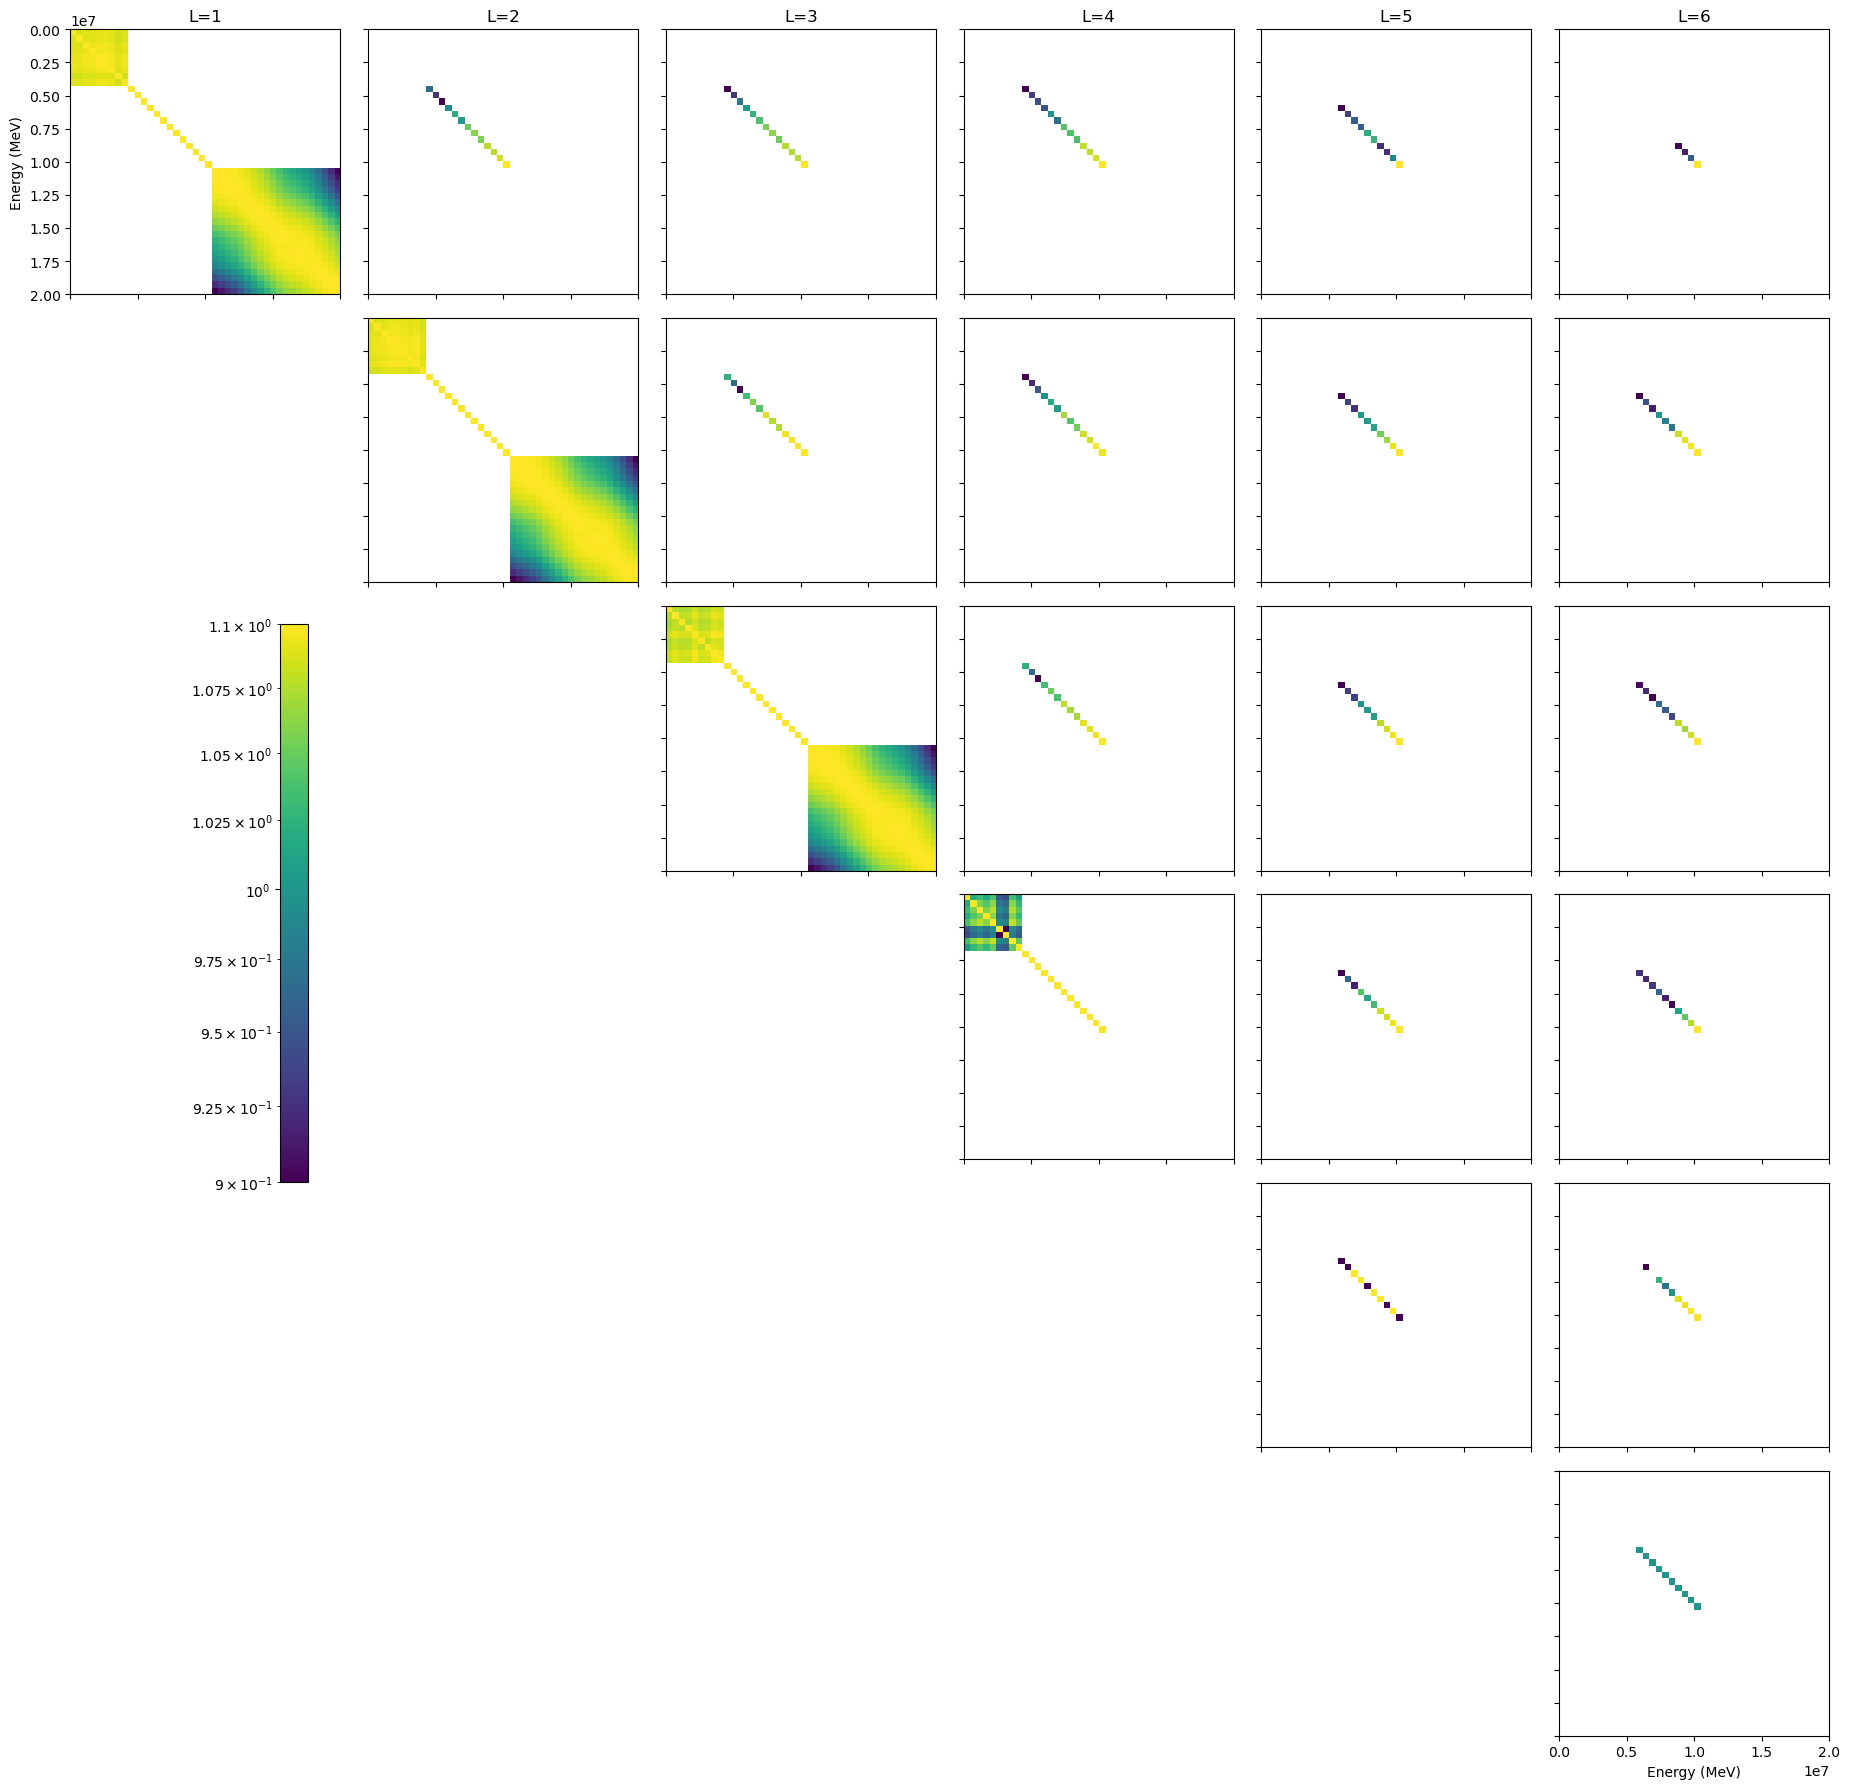

In [77]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18), sharex=True, sharey=True)

N = len(energy_mesh) - 1  # block size

for i in range(6):
    for j in range(6):
        ax = axes[i, j]
        if j < i:
            ax.axis('off')
            continue
        block = full_corr_matrix[i*N:(i+1)*N, j*N:(j+1)*N]
        im = ax.imshow(
            block,
            origin='lower',
            aspect='auto',
            interpolation='none',
            norm=plt.matplotlib.colors.LogNorm(vmin=block[block > 0].min(), vmax=block.max()),
            extent=[energy_mesh[0], energy_mesh[-1], energy_mesh[0], energy_mesh[-1]]
        )
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.invert_yaxis()
        if i == 5:
            ax.set_xlabel('Energy (MeV)')
        if j == 0:
            ax.set_ylabel('Energy (MeV)')
        if i == 0:
            ax.set_title(f'L={j+1}')

# Add a single colorbar for all plots
fig.colorbar(im, ax=axes, location='left', fraction=0.02, pad=0.02)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh):
    original_row_mesh = np.array(sorted(original_row_mesh))
    original_col_mesh = np.array(sorted(original_col_mesh))
    union_row_mesh = np.array(sorted(union_row_mesh))
    union_col_mesh = np.array(sorted(union_col_mesh))

    original_row_size = len(original_row_mesh) - 1
    original_col_size = len(original_col_mesh) - 1
    union_row_size = len(union_row_mesh) - 1
    union_col_size = len(union_col_mesh) - 1

    # For each interval in the union mesh, find to which original interval it belongs
    row_indices = np.searchsorted(original_row_mesh, union_row_mesh[:-1], side='right') - 1
    col_indices = np.searchsorted(original_col_mesh, union_col_mesh[:-1], side='right') - 1

    # Clip to stay within bounds
    row_indices = np.clip(row_indices, 0, original_row_size-1)
    col_indices = np.clip(col_indices, 0, original_col_size-1)

    # Build the expanded matrix by simply picking the right values
    expanded_matrix = original_matrix[np.ix_(row_indices, col_indices)]

    return expanded_matrix


def add_matrices_with_mesh(matrixA, rowMeshA, colMeshA, matrixB, rowMeshB, colMeshB, epsilon=1e-8):
    # Handle trivial cases
    if matrixA.size == 0:
        return matrixB.copy(), sorted(rowMeshB), sorted(colMeshB)
    if matrixB.size == 0:
        return matrixA.copy(), sorted(rowMeshA), sorted(colMeshA)

    rowMeshA = np.array(sorted(rowMeshA))
    colMeshA = np.array(sorted(colMeshA))
    rowMeshB = np.array(sorted(rowMeshB))
    colMeshB = np.array(sorted(colMeshB))

    # Verify mesh-matrix dimension compatibility
    if matrixA.shape != (len(rowMeshA)-1, len(colMeshA)-1):
        raise ValueError("Matrix A and its mesh do not match in size.")
    if matrixB.shape != (len(rowMeshB)-1, len(colMeshB)-1):
        raise ValueError("Matrix B and its mesh do not match in size.")

    # Union of meshes
    def mesh_union(mesh1, mesh2, eps):
        union = np.unique(np.concatenate((mesh1, mesh2)))
        # Merge close values (within epsilon)
        diff = np.diff(union)
        mask = diff < eps
        if np.any(mask):
            keep = np.ones_like(union, dtype=bool)
            keep[1:][mask] = False
            union = union[keep]
        return union

    union_row_mesh = mesh_union(rowMeshA, rowMeshB, epsilon)
    union_col_mesh = mesh_union(colMeshA, colMeshB, epsilon)

    # Expand matrices
    expandedA = expand_matrix_fast(matrixA, rowMeshA, colMeshA, union_row_mesh, union_col_mesh)
    expandedB = expand_matrix_fast(matrixB, rowMeshB, colMeshB, union_row_mesh, union_col_mesh)

    # Add expanded matrices
    result = expandedA + expandedB

    return result, union_row_mesh.tolist(), union_col_mesh.tolist()


original_matrix = np.array([[1, 0],
                            [0, 4]])

original_row_mesh = {0.0, 1.0, 2.0}
original_col_mesh = {0.0, 1.0, 2.0}
union_row_mesh = {0.0, 0.5, 1.0, 1.5, 2.0}
union_col_mesh = {0.0, 0.5, 1.0, 1.5, 2.0}

expanded = expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh)
print(expanded)



[[1 1 0 0]
 [1 1 0 0]
 [0 0 4 4]
 [0 0 4 4]]


In [ ]:
mf4mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(4).MT(2).parse()
mf34mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(34).MT(2).parse()

mt2 = mf34mt2.reactions.to_list()[0]
print(mt2.number_legendre_blocks)
uncertainty = mt2.legendre_blocks.to_list()[0] # Uncertainty between energies of 2 legendre coefficients
print(uncertainty.L, uncertainty.L1, uncertainty.NI)
# for iNI, block in enumerate(uncertainty.data.to_list()):
#     block.energies.to_list()
#     block.
#     b2.values.to_list()[:]

21
1 1 3
